# HMM Personal Project - Improved Version

This project aims to use the Hidden Markov Model to identify different regimes in a Time Series.
The HMM model will be done from scratch, and the results will be validated using external libraries.
An effort is made to use as little external libraries as possible.

## Imports

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Synthetic parameters used to create the time series

In [42]:
# Number of States (now only 2: up bias and down bias)
N = 2

# Number of observations
T = 1000

# Initial probability distribution, two state markov chain
pi = [0.5, 0.5]

# Transition probability matrix (persistent states)
A = np.array([[0.95, 0.05], [0.05, 0.95]])

# Set seed for reproducibility
np.random.seed(34)

## Coin toss model with two states

Let's assume we are looking at coin tosses, and two coins are available.

- **State 1**: Down bias coin (0.7 tails, 0.3 heads) - losing money
- **State 2**: Up bias coin (0.3 tails, 0.7 heads) - gaining money

Say we gain 1 dollar when we hit heads, and lose 1 dollar with tails, we can create a realization of this two-state random walk

In [43]:
# Coin variables
down_bias_tails = 0.7  # State 0: down bias
up_bias_tails = 0.3    # State 1: up bias

# Probability distribution of the observations at each state (emission matrix)
b = np.array([[down_bias_tails, 1-down_bias_tails],  # State 0: down bias
              [up_bias_tails, 1-up_bias_tails]])      # State 1: up bias

## Generate synthetic data

In [44]:
# Set the initial state
rand = np.random.uniform()
lhs = 0
count = 0

# Use the random uniform variable and the distribution to find which state we are starting in
for i in pi:
    if rand <= i + lhs:
        state = count
        break
    lhs += i
    count += 1

# States array
states = [state]

# Realization array
realization = []
running = 0
observations = []

for iteration in range(T):
    # We know which state we start in (which coin we have), we flip the coin
    u = np.random.uniform()
    if state == 0:  # Down bias state
        if u < down_bias_tails:
            running = running - 1
            realization.append(running)
            observations.append(0)  # Tails
        else:
            running = running + 1
            realization.append(running)
            observations.append(1)  # Heads
    else:  # Up bias state
        if u < up_bias_tails:
            running = running - 1
            realization.append(running)
            observations.append(0)  # Tails
        else:
            running = running + 1
            realization.append(running)
            observations.append(1)  # Heads
    
    # Once the flip is done and the score is updated, we may or may not change states
    u2 = np.random.uniform()
    distr = A[state, :]
    lhs = 0
    count = 0
    for j in distr:
        if u2 <= j + lhs:
            state = count
            break
        count += 1
        lhs += j
    states.append(state)

observations = np.array(observations)
states = np.array(states)

## Plot realization and states

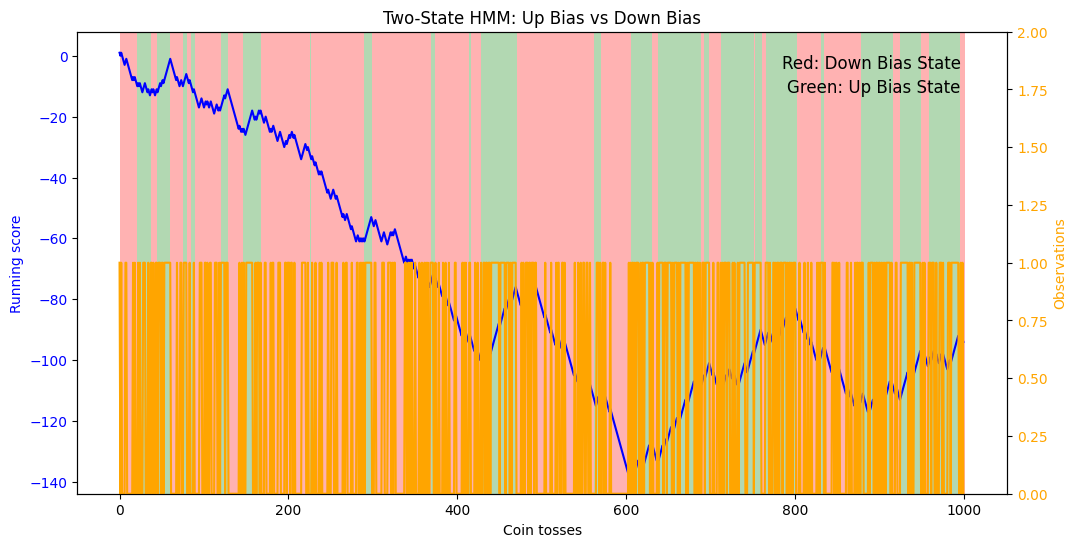

In [45]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(realization, color='blue', label='Realization')
ax1.set_xlabel('Coin tosses')
ax1.set_ylabel('Running score', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Color the background based on states
for i in range(len(states)):
    if states[i] == 0:
        ax1.axvspan(i, i+1, facecolor='red', alpha=0.3)
    elif states[i] == 1:
        ax1.axvspan(i, i+1, facecolor='green', alpha=0.3)

ax1.text(0.95, 0.95, 'Red: Down Bias State', transform=ax1.transAxes, fontsize=12, 
         verticalalignment='top', horizontalalignment='right')
ax1.text(0.95, 0.90, 'Green: Up Bias State', transform=ax1.transAxes, fontsize=12, 
         verticalalignment='top', horizontalalignment='right')

# Creating a second y-axis
ax2 = ax1.twinx()

# Plotting observations on the second axis
ax2.plot(observations, color='orange', label='Observations')
ax2.set_ylabel('Observations', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.set_ylim(0, 2)  # Setting the y-axis limit for the second axis

plt.title('Two-State HMM: Up Bias vs Down Bias')
plt.show()

Now that we have our realization, we will try to find the states and the parameters using the HMM model.

In practice this would be as if we observed someone play the coin-flip game for 1000 flips and are now trying to infer the model from these observations. We do not know the state sequence or the transition probabilities.

To do so, we use the forward-backward algorithm, or Baum-Welch algorithm, which is an EM algorithm.
For this, we need an initial estimate of the A matrix and emission probabilities.

## The Forward Algorithm

The forward algorithm allows us to find the probability of being in state $j$ after seeing the first $t$ observations, given the HMM parameters.

#### Initialization:
$$\alpha_{1}(j)=\pi_{j} b_{j}\left(o_{1}\right) \quad 1 \leq j \leq N$$

#### Recursion:
$$\alpha_{t}(j)=\sum_{i=1}^{N} \alpha_{t-1}(i) a_{i j} b_{j}\left(o_{t}\right) ; \quad 1 \leq j \leq N, 1<t \leq T$$

#### Termination:
$$P(O \mid \lambda)=\sum_{i=1}^{N} \alpha_{T}(i)$$

In [46]:
def compute_forward(N, T, A_f, b_f, pi_f, observations):
    """Forward algorithm"""
    forward = np.zeros((N, T))
    scale_factors = np.zeros(T)
    
    # Initialization
    forward[:, 0] = pi_f[:] * b_f[:, observations[0]]
    
    # Scale to prevent numerical underflow
    scale_factors[0] = np.sum(forward[:, 0])
    forward[:, 0] /= scale_factors[0]
    
    # Recursion
    for t in range(1, T):
        for n in range(N):
            forward[n, t] = np.sum(forward[:, t-1] * A_f[:, n] * b_f[n, observations[t]])
        scale_factors[t] = np.sum(forward[:, t])
        forward[:, t] /= scale_factors[t]
    
    forwardprob = np.sum(forward[:, -1])
    return forward, forwardprob, scale_factors

## The Backward Algorithm

The backward probability $\beta$ is the probability of seeing the observations from time $t+1$ to the end, given that we are in state $i$ at time $t$:

$$\beta_{t}(i)=P\left(o_{t+1}, o_{t+2} \ldots o_{T} \mid q_{t}=i, \lambda\right)$$

#### Initialization:
$$\beta_{T}(i) = 1, \quad 1 \leq i \leq N$$

#### Recursion:
$$\beta_{t}(i) = \sum_{j=1}^{N} a_{i j} b_{j}\left(o_{t+1}\right) \beta_{t+1}(j), \quad 1 \leq i \leq N, \; 1 \leq t < T$$

#### Termination:
$$P(O \mid \lambda) = \sum_{j=1}^{N} \pi_{j} b_{j}\left(o_{1}\right) \beta_{1}(j)$$

In [47]:
def compute_backward(N, T, A_b, b_b, pi_b, observations, scale_factors):
    """Backward algorithm"""
    backward = np.zeros((N, T))
    
    # Initialization
    backward[:, T-1] = 1 / scale_factors[T-1]
    
    # Recursion
    for t in range(T-2, -1, -1):
        for n in range(N):
            backward[n, t] = np.sum(backward[:, t+1] * A_b[n, :] * b_b[:, observations[t+1]])
        backward[:, t] /= scale_factors[t]
    
    return backward

## Compute Gamma (state probabilities)

We need to know the probability of being in state $j$ at time $t$, which we call $\gamma_{t}(j)$:

$$\gamma_{t}(j)=P\left(q_{t}=j \mid O, \lambda\right)$$

This is computed as:

$$\gamma_{t}(j)=\frac{\alpha_{t}(j) \beta_{t}(j)}{P(O \mid \lambda)}$$

In [48]:
def compute_gamma(forward_g, backward_g):
    """Compute gamma (state probabilities)"""
    # Compute unnormalized gamma
    gamma_g = forward_g * backward_g
    
    # Normalize gamma by the total probability of the observations
    gamma_g /= np.sum(gamma_g, axis=0)
    
    return gamma_g

## Compute Xi (transition probabilities)

We define $\xi_{t}(i, j)$ as the probability of being in state $i$ at time $t$ and state $j$ at time $t+1$, given the observation sequence:

$$\xi_{t}(i, j)=P\left(q_{t}=i, q_{t+1}=j \mid O, \lambda\right)$$

This is computed as:

$$\xi_{t}(i, j)=\frac{\alpha_{t}(i) a_{i j} b_{j}\left(o_{t+1}\right) \beta_{t+1}(j)}{\sum_{j=1}^{N} \alpha_{t}(j) \beta_{t}(j)}$$

In [49]:
def compute_xi(N, T, A_x, b_x, observations, forward_x, backward_x, forwardprob_x):
    """Compute xi (transition probabilities)"""
    xi = np.zeros((T, N, N))
    
    for t in range(0, T-1):
        for i in range(N):
            for j in range(N):
                xi[t, i, j] = (forward_x[i, t] * A_x[i, j] * b_x[j, observations[t+1]] * 
                              backward_x[j, t+1]) / np.sum(forward_x[:, t] * backward_x[:, t])
    
    return xi

## Update transition matrix A

The expected number of transitions from state $i$ to state $j$ is the sum over all $t$ of $\xi$. For our estimate of $a_{i j}$:

$$\hat{a}_{i j}=\frac{\sum_{t=1}^{T-1} \xi_{t}(i, j)}{\sum_{t=1}^{T-1} \sum_{k=1}^{N} \xi_{t}(i, k)}$$

In [50]:
def compute_ahat(xi, N):
    """Update transition matrix A"""
    a_hat = np.zeros((N, N))
    
    for i in range(N):
        for j in range(N):
            numerator = np.sum(xi[:-1, i, j])
            denominator = np.sum(xi[:-1, i, :])
            if denominator > 0:
                a_hat[i, j] = numerator / denominator
            else:
                a_hat[i, j] = 1.0 / N  # Default to uniform if no transitions
    
    return a_hat

## Update emission matrix b

For the emission probabilities:

$$\hat{b}_{j}\left(v_{k}\right)=\frac{\sum_{t=1 \text { s.t. } O_{t}=v_{k}}^{T} \gamma_{t}(j)}{\sum_{t=1}^{T} \gamma_{t}(j)}$$

In [51]:
def compute_bhat(N, gam_hat, observations):
    """Update emission matrix b"""
    bhat = np.zeros((N, 2))
    tailsid = np.where(observations == 0)[0]
    headsid = np.where(observations == 1)[0]
    
    for j in range(N):
        total_time_in_state = np.sum(gam_hat[j, :])
        if total_time_in_state > 0:
            bhat[j, 0] = np.sum(gam_hat[j, tailsid]) / total_time_in_state
            bhat[j, 1] = np.sum(gam_hat[j, headsid]) / total_time_in_state
        else:
            bhat[j, 0] = 0.5  # Default to fair coin
            bhat[j, 1] = 0.5
    
    return bhat

## EM Algorithm

The Expectation-Maximization algorithm alternates between:

**E-step:** Compute forward and backward probabilities, then compute $\gamma$ and $\xi$

**M-step:** Update the parameters using the computed probabilities

In [52]:
def EM(N, T, A_m, b_m, pi_m, observations):
    """EM Algorithm"""
    iterations = 1000
    threshold = 1e-6
    prev_log_likelihood = -np.inf
    logr = []
    
    for i in range(iterations):
        # Expectation step
        forw, forwprob, sca = compute_forward(N, T, A_m, b_m, pi_m, observations)
        back = compute_backward(N, T, A_m, b_m, pi_m, observations, sca)
        
        gam_m = compute_gamma(forw, back)
        xi_m = compute_xi(N, T, A_m, b_m, observations, forw, back, forwprob)
        
        # M-step
        A_m = compute_ahat(xi_m, N)
        b_m = compute_bhat(N, gam_m, observations)
        pi_m = gam_m[:, 0]
        
        # Calculate the log-likelihood
        log_likelihood = np.sum(np.log(sca))
        logr.append(log_likelihood)
        
        # Check for convergence
        if np.abs(log_likelihood - prev_log_likelihood) < threshold:
            break
        
        prev_log_likelihood = log_likelihood
    
    print(f"EM algorithm ended after {i+1} iterations")
    return A_m, b_m, pi_m, logr[-1]

## Generate random stochastic matrix

In [53]:
def generate_row_stochastic_matrix(n, m):
    """Generates an n x m matrix where each row sums to 1"""
    matrix = np.random.rand(n, m)
    row_sums = matrix.sum(axis=1, keepdims=True)
    row_stochastic_matrix = matrix / row_sums
    return row_stochastic_matrix

## Run EM with multiple initializations

We try at different starting points and take the one that maximizes the log-likelihood

In [54]:
max_log_likelihood = -np.inf
A_max = None
b_max = None
pi_max = None

print("Running EM algorithm with multiple initializations...")

for i in range(5):
    print(f"Initialization {i+1}/10")
    
    # Use a more persistent initial transition matrix
    A_temp = generate_row_stochastic_matrix(2, 2)
    
    # Initial emission probabilities (down bias, up bias)
    b_temp = generate_row_stochastic_matrix(2, 2)
    
    # Initial state probabilities
    pi_temp = [0.5, 0.5]
    
    A_hat, b_hat, pi_hat, logr = EM(N, T, A_temp, b_temp, pi_temp, observations)
    
    if logr > max_log_likelihood:
        max_log_likelihood = logr
        A_max = A_hat.copy()
        b_max = b_hat.copy()
        pi_max = pi_hat.copy()

print("\n=== TRUE PARAMETERS ===")
print("Transition Matrix A:")
print(A)
print("\nEmission Matrix b:")
print(b)
print("\nInitial Probabilities pi:")
print(pi)

print("\n=== ESTIMATED PARAMETERS ===")
print("Transition Matrix A_hat:")
if A_max is not None:
    print(np.round(A_max, 3))
print("\nEmission Matrix b_hat:")
if b_max is not None:
    print(np.round(b_max, 3))
print("\nInitial Probabilities pi_hat:")
if pi_max is not None:
    print(np.round(pi_max, 3))

Running EM algorithm with multiple initializations...
Initialization 1/10
EM algorithm ended after 136 iterations
Initialization 2/10
EM algorithm ended after 1000 iterations
Initialization 3/10
EM algorithm ended after 113 iterations
Initialization 4/10
EM algorithm ended after 151 iterations
Initialization 5/10
EM algorithm ended after 169 iterations

=== TRUE PARAMETERS ===
Transition Matrix A:
[[0.95 0.05]
 [0.05 0.95]]

Emission Matrix b:
[[0.7 0.3]
 [0.3 0.7]]

Initial Probabilities pi:
[0.5, 0.5]

=== ESTIMATED PARAMETERS ===
Transition Matrix A_hat:
[[0.949 0.051]
 [0.078 0.922]]

Emission Matrix b_hat:
[[0.717 0.283]
 [0.286 0.714]]

Initial Probabilities pi_hat:
[1. 0.]


## Viterbi Algorithm

The Viterbi algorithm finds the most likely state sequence given the observations.

We want to find:
$$v_{t}(j)=\max _{q_{1}, \ldots, q_{t-1}} P\left(q_{1} \ldots q_{t-1}, o_{1}, o_{2} \ldots o_{t}, q_{t}=j \mid \lambda\right)$$

For a given state $q_{j}$ at time $t$, the value $v_{t}(j)$ is computed as:
$$v_{t}(j)=\max _{i=1}^{N} v_{t-1}(i) a_{i j} b_{j}\left(o_{t}\right)$$

#### Initialization:
$$v_{1}(j) = \pi_{j} b_{j}\left(o_{1}\right) \quad 1 \leq j \leq N$$

#### Recursion:
$$v_{t}(j) = \max _{i=1}^{N} v_{t-1}(i) a_{i j} b_{j}\left(o_{t}\right) ; \quad 1 \leq j \leq N, 1<t \leq T$$

#### Termination:
$$P^* = \max_{i=1}^{N} v_{T}(i)$$
$$q_{T}^* = \underset{i=1}{\operatorname{argmax}} v_{T}(i)$$

#### Backtracking:
$$q_{t}^* = \text{backpointer}[q_{t+1}^*, t+1] \quad \text{for } t = T-1, T-2, \ldots, 1$$

In [55]:
def viterbi(N, T, A_hat, b_hat, pi_hat, observations):
    """
    Viterbi algorithm to find the most likely state sequence
    """
    # Initialize Viterbi matrix and backpointers
    viterbi_matrix = np.zeros((N, T))
    backpointers = np.zeros((N, T), dtype=int)
    
    # Initialization
    for j in range(N):
        viterbi_matrix[j, 0] = pi_hat[j] * b_hat[j, observations[0]]
        backpointers[j, 0] = 0  # Not used for t=0
    
    # Recursion
    for t in range(1, T):
        for j in range(N):
            # For each state j at time t, find the previous state i that maximizes the probability
            probs = viterbi_matrix[:, t-1] * A_hat[:, j] * b_hat[j, observations[t]]
            backpointers[j, t] = np.argmax(viterbi_matrix[:, t-1] * A_hat[:, j])
            viterbi_matrix[j, t] = np.max(probs)
    
    # Termination: find the best last state
    best_path = np.zeros(T, dtype=int)
    best_path[T-1] = np.argmax(viterbi_matrix[:, T-1])
    best_path_prob = np.max(viterbi_matrix[:, T-1])
    
    # Backtracking
    for t in range(T-2, -1, -1):
        best_path[t] = backpointers[best_path[t+1], t+1]
    
    return best_path, best_path_prob, viterbi_matrix

## Run Viterbi and evaluate accuracy

## Plotting function

In [56]:
def plot_results(states, predicted_states, viterbi_matrix, T):
    """Plot cumulative accuracy and observed vs predicted states"""
    plt.figure(figsize=(15, 10))
    
    # Calculate cumulative accuracy at each time step
    cumulative_correct = np.cumsum(states == predicted_states)
    cumulative_accuracy = cumulative_correct / np.arange(1, T + 1)
    
    # Plot 1: Cumulative accuracy over time
    plt.subplot(2, 1, 1)
    plt.plot(cumulative_accuracy, linewidth=2, color='blue')
    plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Random Guess (50%)')
    plt.title('Cumulative Accuracy Over Time')
    plt.ylabel('Cumulative Accuracy')
    plt.xlabel('Time Step')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)
    
    # Plot 2: Observed vs Predicted States
    plt.subplot(2, 1, 2)
    plt.plot(states, label='True States', linewidth=2, color='blue')
    plt.plot(predicted_states, label='Predicted States', linewidth=2, color='red', linestyle='--')
    plt.title('State Prediction: True vs Predicted')
    plt.ylabel('State')
    plt.xlabel('Time Step')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.show()

## Detailed accuracy analysis

In [57]:
def detailed_accuracy_analysis(states, predicted_states, T, N):
    """Perform detailed accuracy analysis"""
    accuracy = np.mean(predicted_states == states)
    
    print(f"\n=== DETAILED ACCURACY ANALYSIS ===")
    print(f"Total observations: {T}")
    print(f"Correct predictions: {np.sum(predicted_states == states)}")
    print(f"Accuracy: {accuracy:.3f}")
    
    # State-specific accuracy
    for state in range(N):
        state_mask = states == state
        if np.any(state_mask):
            state_accuracy = np.mean(predicted_states[state_mask] == states[state_mask])
            print(f"State {state} accuracy: {state_accuracy:.3f} ({np.sum(state_mask)} observations)")
    
    # Transition accuracy
    correct_transitions = 0
    total_transitions = 0
    for t in range(1, T):
        if predicted_states[t] == states[t] and predicted_states[t-1] == states[t-1]:
            correct_transitions += 1
        total_transitions += 1
    
    if total_transitions > 0:
        transition_accuracy = correct_transitions / total_transitions
        print(f"Transition accuracy: {transition_accuracy:.3f}")

## Parameter comparison

In [58]:
def parameter_comparison(A, b, pi, A_max, b_max, pi_max):
    """Compare estimated parameters with true parameters"""
    print(f"\n=== PARAMETER COMPARISON ===")
    print("Transition Matrix Error:")
    transition_error = np.mean(np.abs(A - A_max))
    print(f"Mean absolute error: {transition_error:.3f}")
    
    print("\nEmission Matrix Error:")
    emission_error = np.mean(np.abs(b - b_max))
    print(f"Mean absolute error: {emission_error:.3f}")
    
    print("\nInitial Probability Error:")
    initial_error = np.mean(np.abs(np.array(pi) - pi_max))
    print(f"Mean absolute error: {initial_error:.3f}")


=== VITERBI RESULTS ===
Path probability: 0.000000
State prediction accuracy: 0.829 (82.9%)


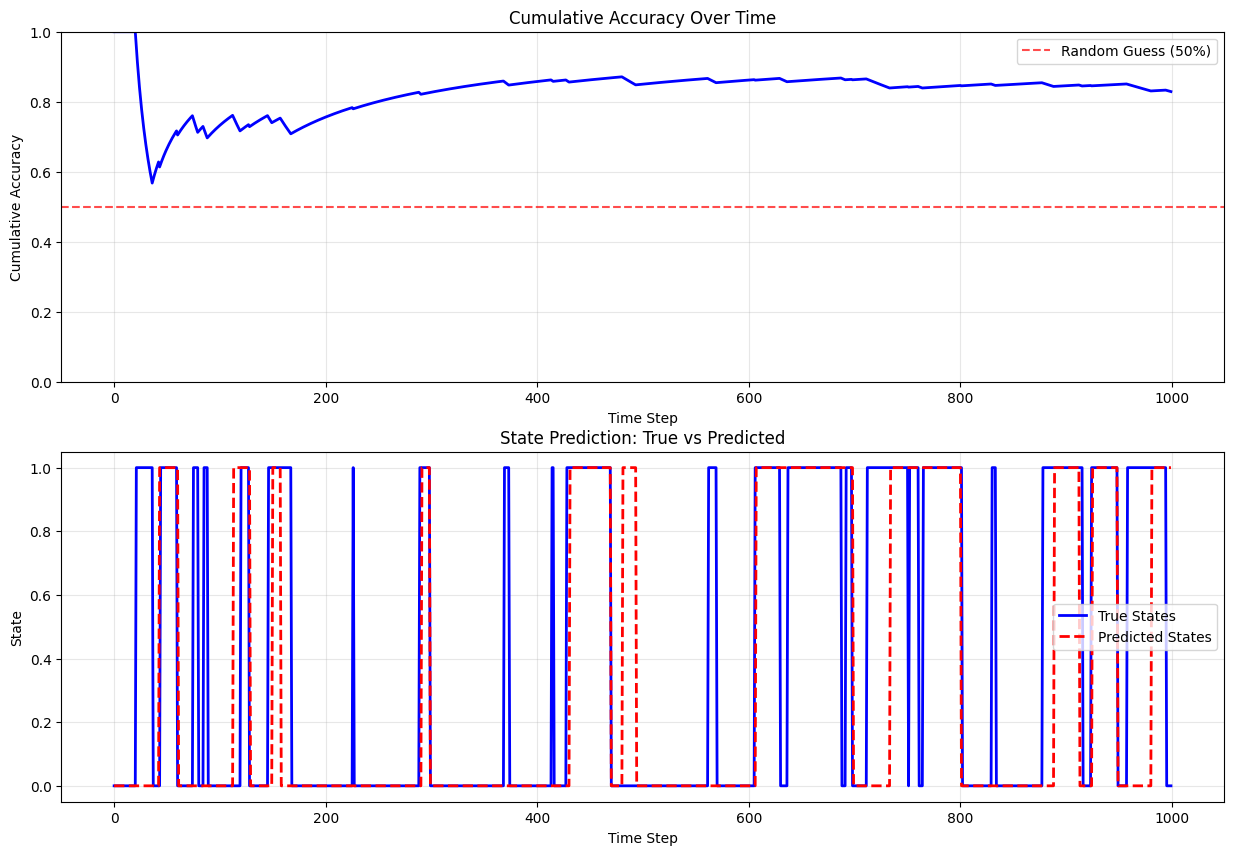


=== DETAILED ACCURACY ANALYSIS ===
Total observations: 1000
Correct predictions: 829
Accuracy: 0.829
State 0 accuracy: 0.924 (591 observations)
State 1 accuracy: 0.692 (409 observations)
Transition accuracy: 0.800

=== PARAMETER COMPARISON ===
Transition Matrix Error:
Mean absolute error: 0.015

Emission Matrix Error:
Mean absolute error: 0.015

Initial Probability Error:
Mean absolute error: 0.500


In [59]:
# Run Viterbi algorithm
predicted_states, path_prob, viterbi_matrix = viterbi(N, T, A_max, b_max, pi_max, observations)

# Calculate accuracy
accuracy = np.mean(predicted_states == states[:T])
print(f"\n=== VITERBI RESULTS ===")
print(f"Path probability: {path_prob:.6f}")
print(f"State prediction accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")

# Plot results
plot_results(states[:T], predicted_states, viterbi_matrix, T)

# Detailed accuracy analysis
detailed_accuracy_analysis(states[:T], predicted_states, T, N)

# Compare with true parameters
parameter_comparison(A, b, pi, A_max, b_max, pi_max)